<a href="https://colab.research.google.com/github/ZHANGZ1YUE/Rainfall_Nowcasting/blob/main/ResUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Convolutional Encoder Decoder Model
#Author: ZHANG Ziyue (Kyoto University)
#Date: 2011/11/3

from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Research/Simulation_Result/30mins_4ch

Mounted at /content/drive/
/content/drive/MyDrive/Research/Simulation_Result/30mins_4ch


In [ ]:
import numpy as np
import os
from keras.models import *
from keras.layers import *
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers


In [ ]:
def res_block(inputs, filter_num, filter_size): 
    x = Activation(activation='relu')(inputs)
    x = Conv2D(filter_num, filter_size, padding = 'same', kernel_initializer = 'glorot_normal')(x)
    x = Activation(activation='relu')(x)
    x = Conv2D(filter_num, filter_size, padding = 'same', kernel_initializer = 'glorot_normal')(x)

    shortcut = Conv2D(filter_num, (1, 1), padding='same', kernel_initializer = 'glorot_normal')(inputs)
    shortcut = BatchNormalization()(shortcut)

    residual = Add()([x, shortcut])
    return residual

def net():
    
    inputs = Input((192, 128, 4))


    conv1 = res_block(inputs, 64, 3)
    

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = res_block(pool1, 128, 3)
    

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = res_block(pool2, 256, 3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = res_block(pool3, 512, 3)
    

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = res_block(pool4, 1024, 3)

    up6 = UpSampling2D(size = (2,2))(conv5)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = res_block(merge6, 512, 3)

    up7 = UpSampling2D(size = (2,2))(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = res_block(merge7, 256, 3)

    up8 = UpSampling2D(size = (2,2))(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = res_block(merge8, 128, 3)

    up9 = UpSampling2D(size = (2,2))(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = res_block(merge9, 64, 3)
    
    outputs = Conv2D(1, 1, activation='linear')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)

    return model

#然后validation改成20%，这个意思就是这最后20不会被用来traintrain
#然后挑选"validation"也就是最后20%的data中的几个sample，plot出来input，prediction和ground truth

In [ ]:
input = np.load('./paddedinput_30mins_4ch.npy')
output = np.load('./paddedoutput_30mins_4ch.npy')


model = net()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='log_cosh', metrics=['accuracy'])
result = model.fit(input, output, epochs=100, validation_split=0.2)
model.save('Unet_30mins_4ch_100ep_nodrop_res.h5')

Epoch 1/100
15/15 [==============================] - 92s 4s/step - loss: 1.6070 - accuracy: 0.3425 - val_loss: 2.5704 - val_accuracy: 0.5198
Epoch 2/100
15/15 [==============================] - 29s 2s/step - loss: 1.2396 - accuracy: 0.4334 - val_loss: 1.3003 - val_accuracy: 0.5273
Epoch 3/100
15/15 [==============================] - 29s 2s/step - loss: 1.1646 - accuracy: 0.4371 - val_loss: 0.8526 - val_accuracy: 0.5802
Epoch 4/100
15/15 [==============================] - 29s 2s/step - loss: 1.1302 - accuracy: 0.4436 - val_loss: 0.8555 - val_accuracy: 0.5601
Epoch 5/100
15/15 [==============================] - 29s 2s/step - loss: 1.0892 - accuracy: 0.4465 - val_loss: 0.6400 - val_accuracy: 0.5664
Epoch 6/100
15/15 [==============================] - 29s 2s/step - loss: 1.0690 - accuracy: 0.4494 - val_loss: 0.6333 - val_accuracy: 0.5740
Epoch 7/100
15/15 [==============================] - 29s 2s/step - loss: 1.0294 - accuracy: 0.4549 - val_loss: 0.5844 - val_accuracy: 0.5772
Epoch 8/100
1

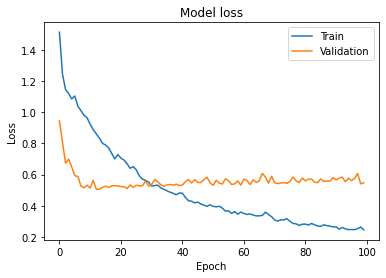

In [ ]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.ylim(-0.1, 0.2)
plt.show()

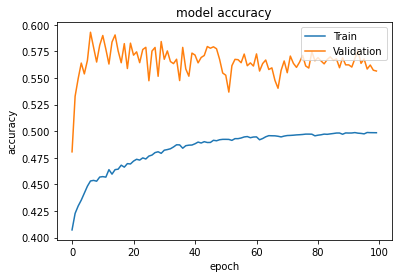

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()